In [1]:
# pip install jiwer

In [2]:
import cv2, re
import warnings
import torch, io
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image as ImagePIL
from google.cloud import vision
from datasets import load_metric
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from google.cloud.vision_v1.types import Image
from sklearn.model_selection import train_test_split
from google.oauth2.service_account import Credentials
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments,\
                         TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator, AutoTokenizer

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('data/ocr/labels.xlsx')

df['ImageID'] = df.index + 1 
df['ImageName'] = df['ImageID'].apply(lambda x: str(x) + '.png')
del df['ImageID']

# drop rows with empty text
df = df[df['caption'].notna()]
df.head()

,caption,ImageName
0,මාළු පැටවා,1.png
1,මාළු,2.png
2,පැටවා,3.png
3,මාළු පැටවෙක්,4.png
4,පොකුණේ සතුටින් පීනුවා,5.png


රිදී එළිය හැමතැන ම වැටිලා.
බබා හැමදාම කිරි විතරක් බීවා . කිරි
තරම් චූටි බබෙකු නොවෙයි
කවුරුත් බබාට කීවේ
බත් කෑ කිරී උස මහත වෙලා බරවුණා .
කිවිවා වගේම ටික දවසකින්
ඒ බබා වෙන
මේසන් බාස් උන්නැහෙයි මේකට වැරදිකාරයා. අච්චාරු
බබා බත් කෑවේ නෑ
දොරකඩ වතුර දාන මුදලාලියි මේකට වැරදිකාරයා .
කිරී බිම බැලුවා
කෝපි බොන්න කඩේ ඇතුළට ගියා.
ඉස්‌ ඉස්සෙල්ලා කෑම කන
කතාව සහ චිත්‍ර
වලාකුළුත්‌ පසු කරලා
තාත්තත්‌ එකතු වෙලා මේසෙ
ගෙට පැන්නා. අම්මා ළගටම
කතාව සහ චිත්‍ර
ඒ මැද අපූරැවට වාඩි වෙලා සිටියේ කුඩ හොරා.
අම්මා කීවා.


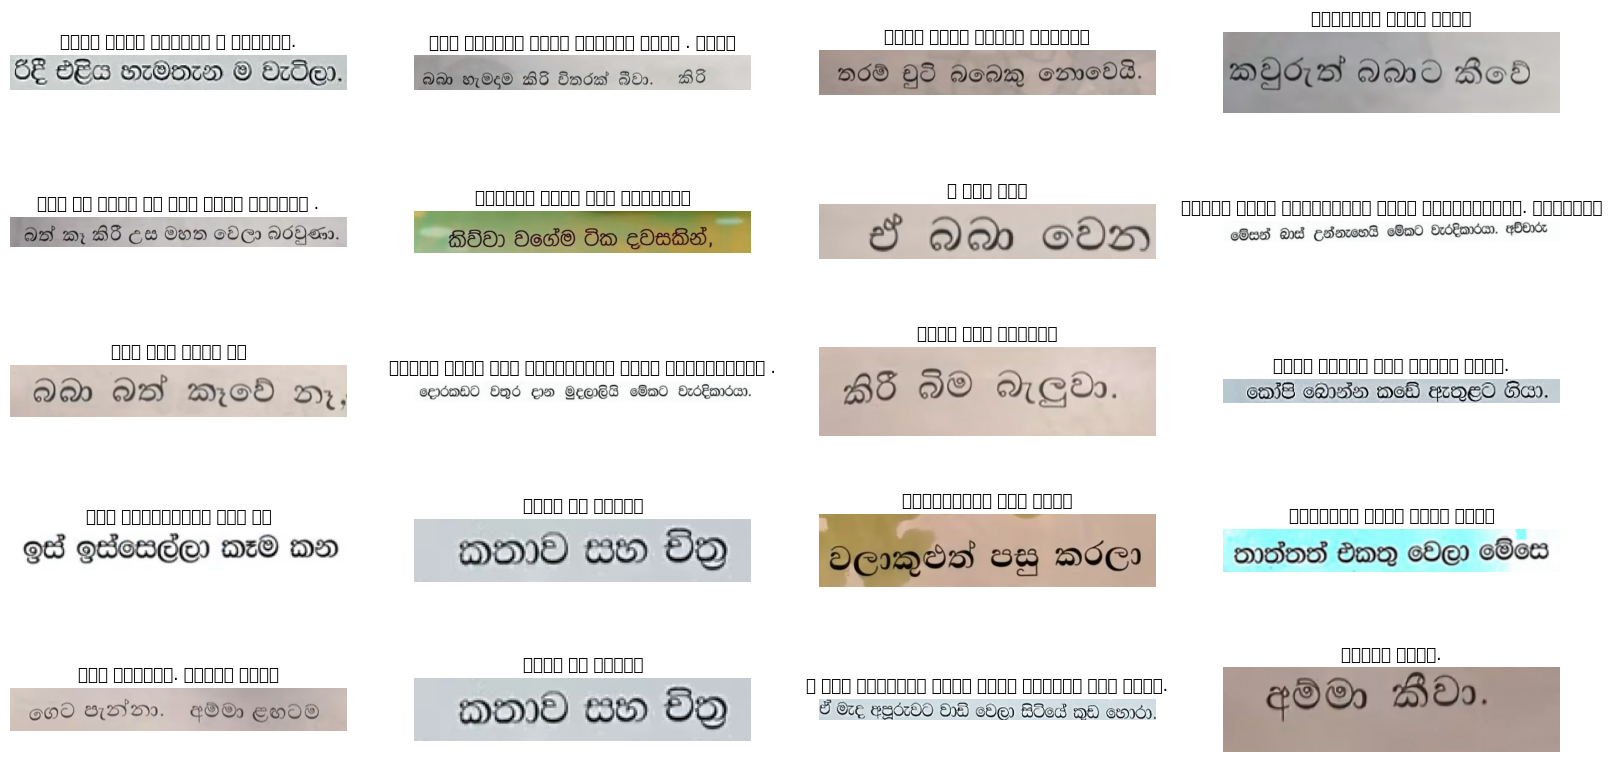

In [5]:
# visulize 20 images 5 rows 4 columns
rand_idxs = np.random.randint(0, len(df), 20)
fig = plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(5, 4, i+1)
    img_path = f"data/ocr/images/{df.iloc[rand_idxs[i]]['ImageName']}"
    img = cv.imread(img_path)
    plt.imshow(img)
    print(df.iloc[rand_idxs[i]]['caption'])
    plt.title(df.iloc[rand_idxs[i]]['caption'])
    plt.axis('off')
plt.show()

In [6]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
tokenizer = AutoTokenizer.from_pretrained("keshan/SinhalaBERTo")
processor.tokenizer = tokenizer
model.to("cpu")

print("Model and Processor Ready !!!")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Model and Processor Ready !!!


In [7]:
all_texts = df['caption'].tolist()
all_texts = [text.lower() for text in all_texts]
all_tokens = [processor.tokenizer.tokenize(text) for text in all_texts]
all_token_lengths = [len(tokens) for tokens in all_tokens]
all_token_length_series = pd.Series(all_token_lengths)
all_token_length_series.describe(
    percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    381.000000
mean      19.887139
std       10.154873
min        1.000000
25%       12.000000
50%       18.000000
75%       28.000000
90%       34.000000
95%       38.000000
99%       41.200000
max       44.000000
dtype: float64

In [8]:
df = pd.read_fwf('data/ocr1/gt_test.txt', header=None)
df.rename(columns={
                    0: "file_name", 
                    1: "text"
                    }, 
          inplace=True)
del df[2]

df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

In [9]:
# get idxs where max token length is less than 30 
idxs = all_token_length_series[all_token_length_series < 30].index.tolist()
df = df.iloc[idxs]

In [10]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [11]:
class IAMDataset(Dataset):
    def __init__(
                self, 
                root_dir, 
                df, 
                processor, 
                max_target_length=30
                ):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = ImagePIL.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        labels = self.processor.tokenizer(
                                          text, 
                                          padding="max_length",
                                          max_length=self.max_target_length
                                          ).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {
                    "pixel_values": pixel_values.squeeze(), 
                    "labels": torch.tensor(labels)
                    }
        return encoding

In [12]:

train_dataset = IAMDataset(
                        root_dir='data/ocr1/image/',
                        df=train_df,
                        processor=processor
                        )
eval_dataset = IAMDataset(
                        root_dir='data/ocr1/image/',
                        df=test_df,
                        processor=processor
                        )

In [13]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 236
Number of validation examples: 59


In [14]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([30])


In [15]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

to make the strongest criticisms. He said


In [16]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 30
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

cer_metric = load_metric("cer")

In [17]:
training_args = Seq2SeqTrainingArguments(
                                        output_dir="models/sinhala-ocr-checkpoints",
                                        predict_with_generate=True,
                                        evaluation_strategy="steps",
                                        per_device_train_batch_size=4,
                                        per_device_eval_batch_size=4,
                                        fp16=False, 
                                        logging_steps=8,
                                        save_steps=1000,
                                        eval_steps=1000,
                                        )

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [18]:
trainer = Seq2SeqTrainer(
                        model=model,
                        tokenizer=processor.feature_extractor,
                        args=training_args,
                        compute_metrics=compute_metrics,
                        train_dataset=train_dataset,
                        eval_dataset=eval_dataset,
                        data_collator=default_data_collator,
                        )
trainer.train()

  0%|          | 0/177 [00:00<?, ?it/s]

{'loss': 10.1857, 'learning_rate': 4.7740112994350286e-05, 'epoch': 0.14}


IndexError: index out of range in self

In [19]:
# save model
trainer.save_model("./checkpoints")

In [20]:
# load model
model = VisionEncoderDecoderModel.from_pretrained("./checkpoints")
model.to("cpu")


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=76

# Inference

In [21]:
creds = Credentials.from_service_account_file('cadentials/credentials.json')
client = vision.ImageAnnotatorClient(credentials=creds)

In [22]:
def detect_handwritten_text(path):
    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = Image(content=content)
    response = client.document_text_detection(image=image)
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    
    page = response.full_text_annotation.pages[0]
    parapgraph_texts = ''
    for block in page.blocks:
        parapgraph_text = ''
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                word_text = ''.join([
                    symbol.text for symbol in word.symbols
                ])
                parapgraph_text += word_text + ' '
        parapgraph_texts += parapgraph_text + ' '
    return parapgraph_texts

def detect_sinhala_text(path):
    image_cv  = cv2.imread(path)
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    height_im, width_im, _ = image_cv.shape

    if height_im < width_im:
        image_cv = cv2.rotate(image_cv, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = Image(content=content)
    response = client.document_text_detection(image=image)
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    
    page = response.full_text_annotation.pages[0]
    parapgraph_texts = ''
    for block in page.blocks:
        parapgraph_text = ''
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                word_text = ''.join([
                    symbol.text for symbol in word.symbols
                ])

                parapgraph_text += word_text + ' '
        parapgraph_text = parapgraph_text.replace('\n', '')
        parapgraph_texts += parapgraph_text + '\n'

    # parapgraph_texts = re.sub(r'[a-zA-Z0-9]', '', parapgraph_texts)
    return parapgraph_texts


In [23]:
print(detect_sinhala_text('test_images/2.jpeg'))

පැන්නම උඩ විසි වුණා . එක සැරේටම බිම 
වැටුණෙත් නෑ . එක දවසක් කිරී මිදුලේ සෙල්ලම් කළා . ටිකක් සැරෙන් හුළඟක් ආවා . 

